In [4]:
import napari 
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
from pandas import DataFrame, Series  # for convenience
import nd2
import trackpy as tp
import skimage as sk
import scipy as sp
from PIL import Image
from cellpose import models, io

/Users/lancetdenes/opt/miniconda3/envs/cpnap-env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


original file crawler to get through triclops outdirs 

In [13]:
image_dir = '/Volumes/GoogleDrive/My Drive/postdoc/Raw_Data/20230119_runx2_tracking/Experiment'
imdir_list = [f for f in os.listdir(image_dir) if not f.startswith('.') and 'nuc_ims' not in f]
imlist = []
metalist = []
for f in imdir_list:
    if 'LTD4' in f:
        dir_list = os.listdir(os.path.join(image_dir, f))
        for item in dir_list:
            if 'meta' in item:
                metadata = item
                metalist.append(os.path.join(image_dir, f, metadata))
            elif '.tif' in item:
                image = item
                imlist.append(os.path.join(image_dir, f, image))

            else:
                continue

making new directorires for separated images of interest

In [5]:
exp_path = '/Volumes/GoogleDrive/My Drive/postdoc/Raw_Data/20230119_runx2_tracking'
nucpath = os.path.join(exp_path, 'nuc_ims')
spt_path = os.path.join(exp_path, 'spt_stacks')
if not os.path.exists(nucpath):
   os.mkdir(nucpath)
if not os.path.exists(spt_path):
   os.mkdir(spt_path)   

saving median collapsed nucleus and spt images

In [26]:
for item in imlist:
    stack = sk.io.imread(item)
    nuc = stack[:,0,:,:]
    nuc = np.median(nuc, axis=0)
    sk.io.imsave(os.path.join(nucpath, item.split('/')[-1]), nuc)
    sk.io.imsave(os.path.join(spt_path, item.split('/')[-1]), stack[:,1,:,:])

/var/folders/fx/s_bk043x2yd924px760sz29w0000gn/T/ipykernel_51200/2885747676.py:6: UserWarning: /Volumes/GoogleDrive/My Drive/postdoc/Raw_Data/20230119_runx2_tracking/spt_stacks/LTD4_ctrl_7_MMStack_Pos0.ome.tif is a low contrast image
  sk.io.imsave(os.path.join(spt_path, item.split('/')[-1]), stack[:,1,:,:])
/var/folders/fx/s_bk043x2yd924px760sz29w0000gn/T/ipykernel_51200/2885747676.py:6: UserWarning: /Volumes/GoogleDrive/My Drive/postdoc/Raw_Data/20230119_runx2_tracking/spt_stacks/LTD4_100mm20min_9_MMStack_Pos0.ome.tif is a low contrast image
  sk.io.imsave(os.path.join(spt_path, item.split('/')[-1]), stack[:,1,:,:])
/var/folders/fx/s_bk043x2yd924px760sz29w0000gn/T/ipykernel_51200/2885747676.py:6: UserWarning: /Volumes/GoogleDrive/My Drive/postdoc/Raw_Data/20230119_runx2_tracking/spt_stacks/LTD4_100mm20min_5_MMStack_Pos0.ome.tif is a low contrast image
  sk.io.imsave(os.path.join(spt_path, item.split('/')[-1]), stack[:,1,:,:])
/var/folders/fx/s_bk043x2yd924px760sz29w0000gn/T/ipykernel

trackpy optimization cells

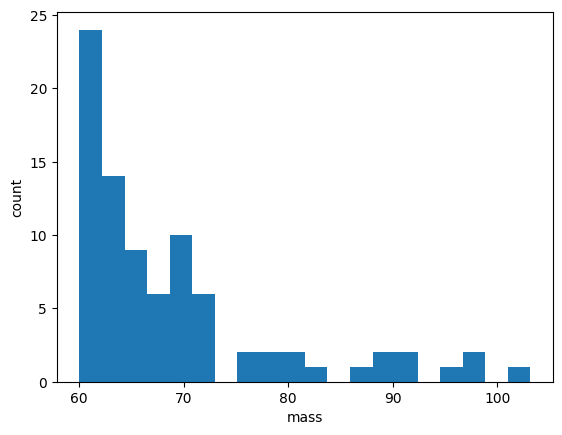

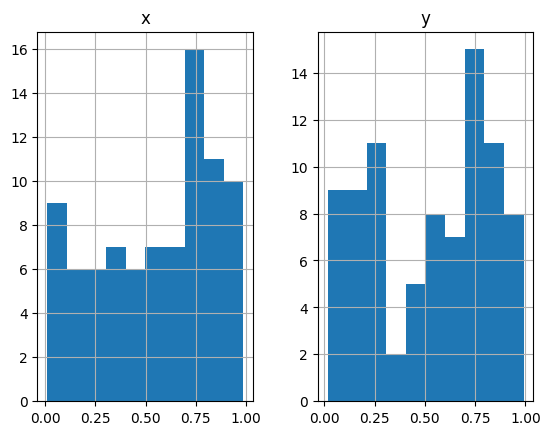

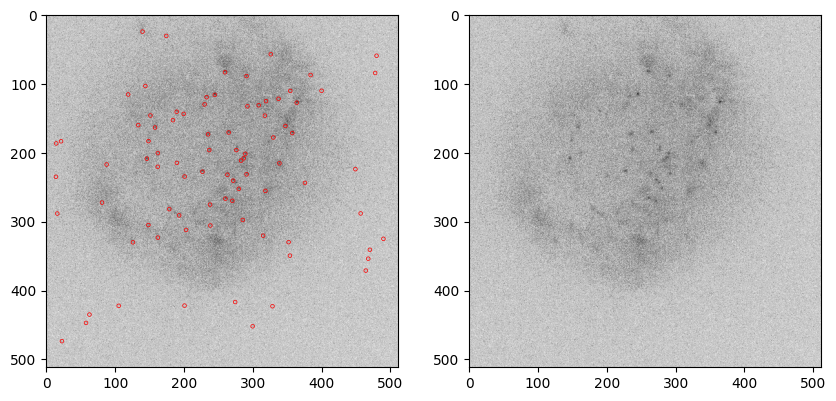

In [15]:
nuc = im[:,0,:,:]
spt = im[:,1,:,:]
analyze = Image.fromarray(spt[0])
#analyze = analyze.resize([250,250])
f = tp.locate(analyze, 9, minmass=60, separation=3)#, percentile=95)
'''viewer = napari.view_image(spt)
viewer.add_image(nuc)
viewer.add_points(f[['y', 'x']])
'''
fig, ax = plt.subplots()
ax.hist(f['mass'], bins=20)
# Optionally, label the axes.
ax.set(xlabel='mass', ylabel='count')
plt.show()
tp.subpx_bias(f)
plt.show()

fig,(ax1,ax2)=plt.subplots(1,2, figsize=(10,10))
ax1.imshow(analyze, cmap='Greys')
ax1.scatter(f['x'],f['y'], facecolors='none', edgecolors='r', linewidth=.5, s=7)
ax2.imshow(analyze, cmap='Greys')
plt.show()

load cell pose model 

In [48]:
model = models.CellposeModel(pretrained_model='/Volumes/GoogleDrive/My Drive/postdoc/Raw_Data/20230119_runx2_tracking/cellpose_residual_on_style_on_concatenation_off_spt_nuc_training_2023_01_30_21_13_04.339757')

generate new file list and go through to start doing the actual work 

In [6]:
flist = [f for f in os.listdir(spt_path) if f.endswith('.tif')]
exp_path = '/Volumes/GoogleDrive/My Drive/postdoc/Raw_Data/20230119_runx2_tracking'
nucpath = os.path.join(exp_path, 'nuc_ims')
spt_path = os.path.join(exp_path, 'spt_stacks')
cp_path = os.path.join(exp_path, 'cp_output')
tracks_path = os.path.join(exp_path, 'tracks')
vals_path = os.path.join(exp_path, 'vals')
cp_plots = os.path.join(exp_path, 'cp_plots')
tracks_plot = os.path.join(exp_path, 'tracks_plot')
data_list = [nucpath, spt_path, cp_path, tracks_path, vals_path, cp_plots, tracks_plot]
for path in data_list:
    if not os.path.exists(path):
        os.mkdir(path)

run cellpose

In [68]:
for f in flist: 
    nucfile = os.path.join(nucpath, f)
    nucim = sk.io.imread(nucfile)
    cp_plot = os.path.join(cp_plots, f.split('.tif')[0]+'.png')
    cpfile = os.path.join(cp_path, f.split('.tif')[0])
    masks, flows, styles = model.eval(nucim)
    io.save_masks(nucim, masks, flows, cpfile)
    fig,(ax1,ax2) = plt.subplots(1,2)
    ax1.imshow(nucim, cmap='Greys')
    ax2.imshow(masks, cmap='Greys')
    plt.savefig(cp_plot, dpi=300)
    plt.close()


run tracking

Frame 999: 50 trajectories present.


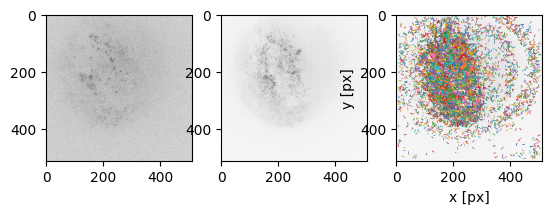

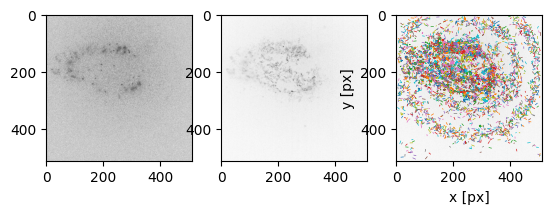

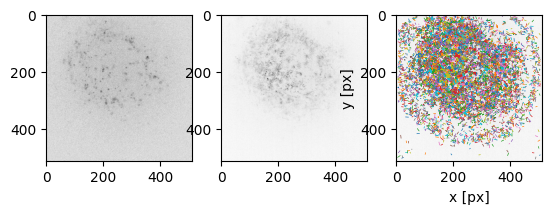

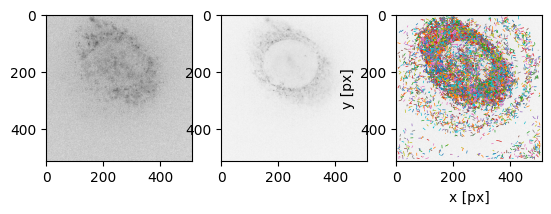

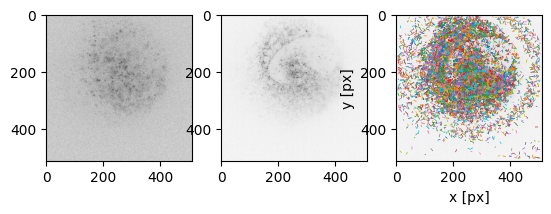

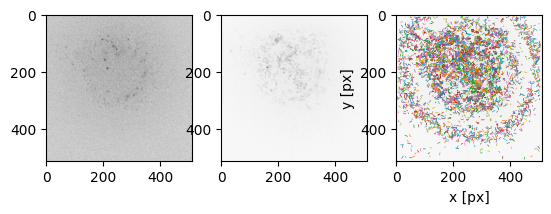

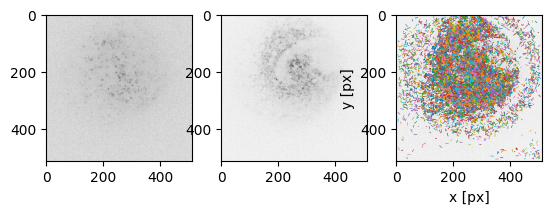

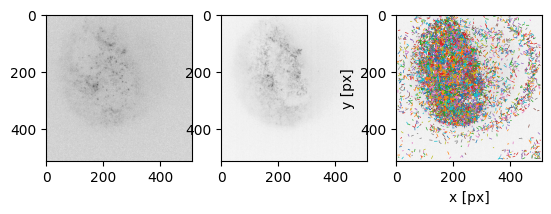

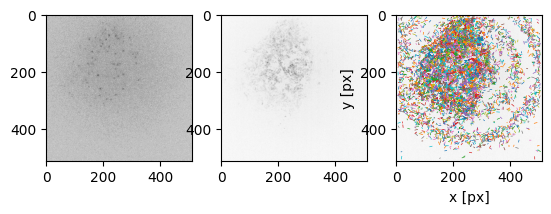

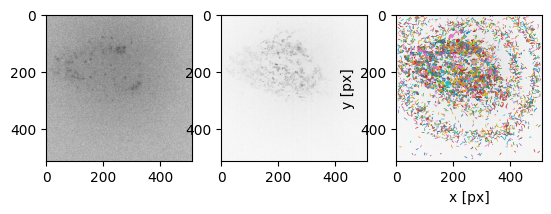

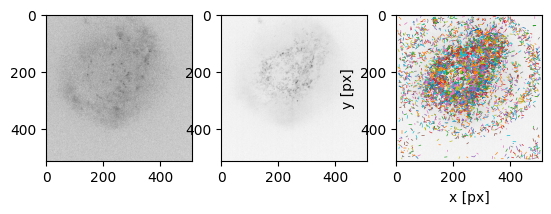

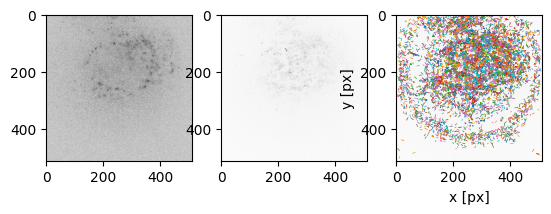

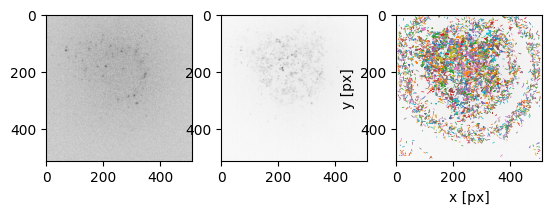

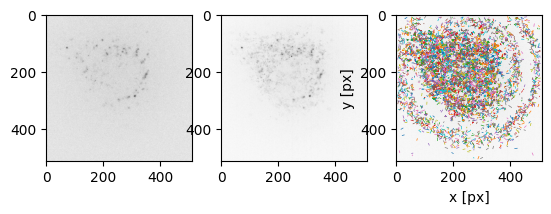

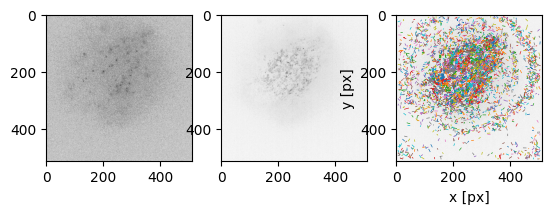

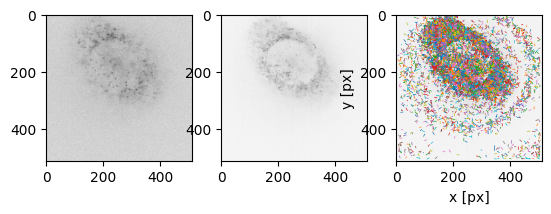

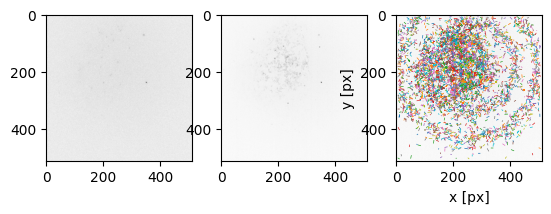

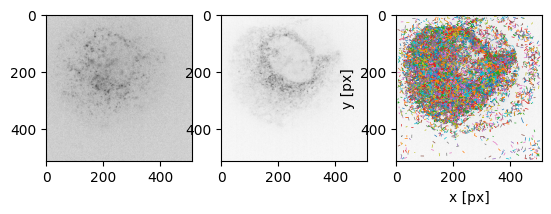

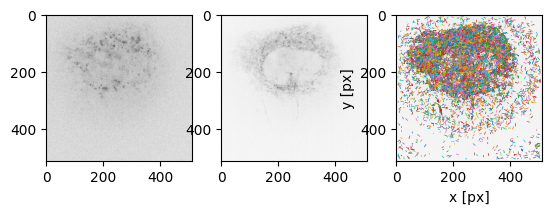

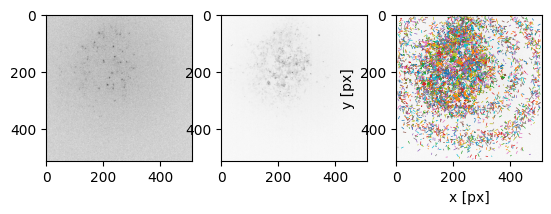

In [84]:
for f in flist: 
    sptfile = os.path.join(spt_path, f)
    cpfile = os.path.join(cp_path, f.split('.')[0]+'_cp_masks.png')
    tracksfile = os.path.join(tracks_path, f.split('.tif')[0]+'.csv')
    tracks_plot_file = os.path.join(tracks_plot, f.split('.tif')[0]+'.png')
    sptim = sk.io.imread(sptfile)
    nuc_mask = sk.io.imread(cpfile)
    f = tp.batch(sptim, 9, minmass=60, separation=3, processes='auto')
    raw_tracks = tp.link(f, 10, memory=2)
    raw_tracks['compartment'] = 'cyto'
    raw_tracks.loc[nuc_mask[raw_tracks['y'].astype(int), raw_tracks['x'].astype(int)] > 0, 'compartment'] = 'nuc'
    raw_tracks.to_csv(tracksfile)
    fig,(ax1,ax2,ax3) = plt.subplots(1,3)
    ax1.imshow(sptim[0,:,:], cmap='Greys')
    ax2.imshow(np.amax(sptim, axis=0), cmap='Greys')
    ax3.imshow(np.amax(sptim, axis=0), cmap='Greys')
    tp.plot_traj(raw_tracks, ax=ax3, plot_style={'lw': .5})
    plt.savefig(tracks_plot_file, dpi=300)


Before: 36267
After: 4947
Before: 36063
After: 3742
Before: 41319
After: 7889
Before: 38472
After: 6759
Before: 40902
After: 8573
Before: 35668
After: 3213
Before: 39143
After: 7738
Before: 37419
After: 6011
Before: 37967
After: 4423
Before: 35612
After: 3457
Before: 34909
After: 3287
Before: 38755
After: 5175
Before: 35848
After: 3792
Before: 36839
After: 5156
Before: 33481
After: 2517
Before: 36189
After: 5702
Before: 36613
After: 2936
Before: 43000
After: 10534
Before: 39099
After: 7822
Before: 38295
After: 3634


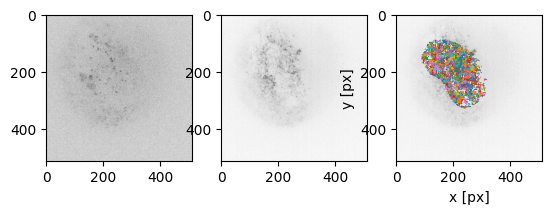

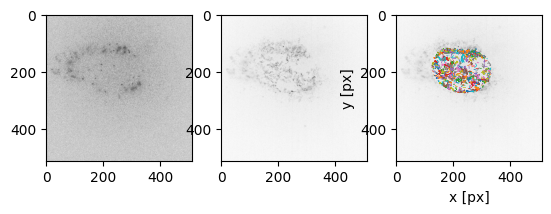

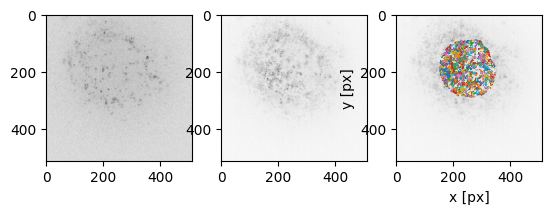

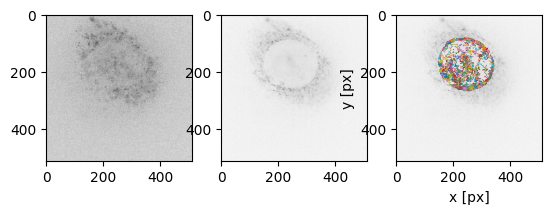

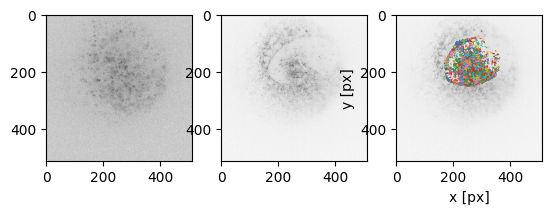

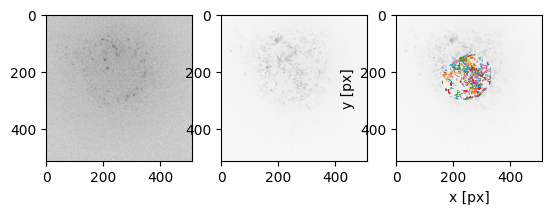

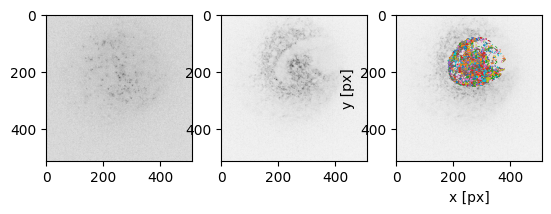

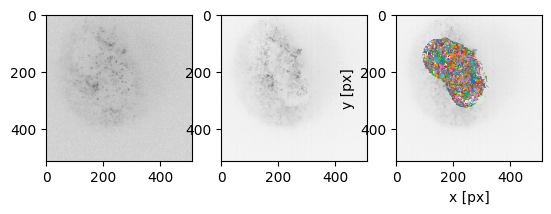

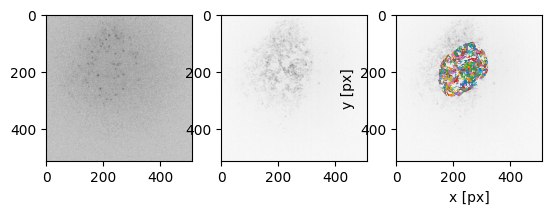

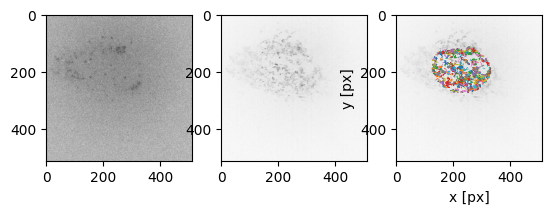

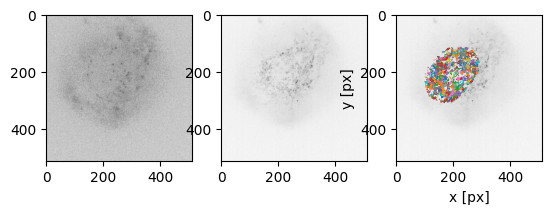

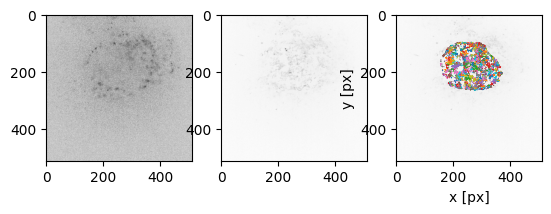

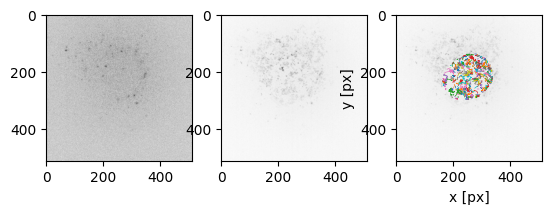

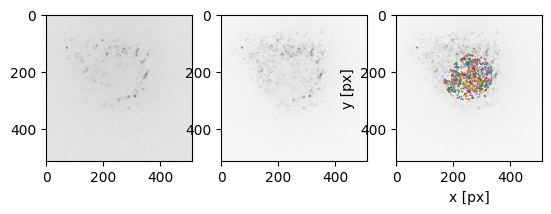

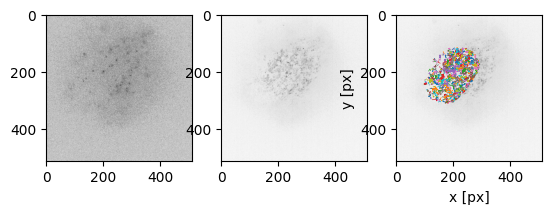

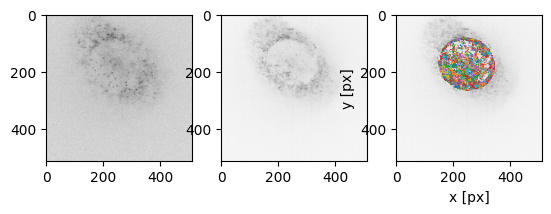

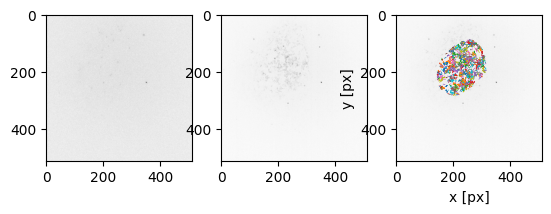

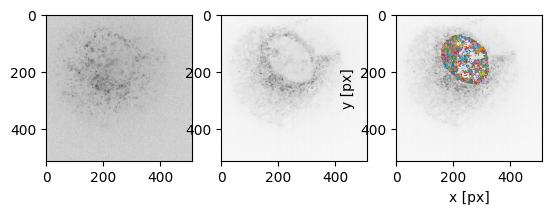

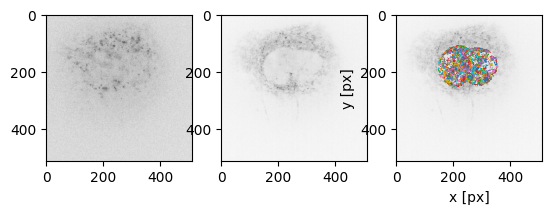

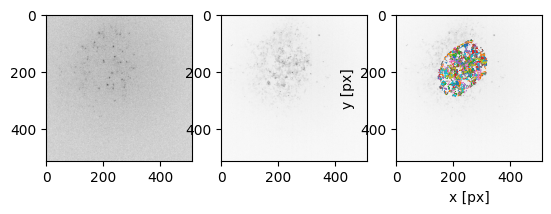

In [86]:
for f in flist:
    sptfile = os.path.join(spt_path, f)
    sptim = sk.io.imread(sptfile)
    tracksfile = os.path.join(tracks_path, f.split('.tif')[0]+'.csv')
    t=pd.read_csv(tracksfile)
    t1 = tp.filter_stubs(t, 3)
    fig,(ax1,ax2,ax3) = plt.subplots(1,3)
    ax1.imshow(sptim[0,:,:], cmap='Greys')
    ax2.imshow(np.amax(sptim, axis=0), cmap='Greys')
    ax3.imshow(np.amax(sptim, axis=0), cmap='Greys')
    tp.plot_traj(t1[t1['compartment'] == 'nuc'], ax=ax3, plot_style={'lw': .5})
    print('Before:', t['particle'].nunique())
    print('After:', t1['particle'].nunique())
    tracks_plot_file = os.path.join(tracks_plot, f.split('.tif')[0]+'.png')
    plt.savefig(tracks_plot_file, dpi=300)


run trackpy and filter tracks to 3 

In [7]:
f = flist[10]
tracksfile = os.path.join(tracks_path, f.split('.tif')[0]+'.csv')
sptfile = os.path.join(spt_path, f)
sptim = sk.io.imread(sptfile)

In [8]:
print(sptim.shape)
t=pd.read_csv(tracksfile)
t1 = tp.filter_stubs(t, 3)
tracks = t1.fillna(0.)
for_nap = tracks[['particle', 'frame', 'y', 'x']]
for_nap.columns = ['track_id', 'time', 'y', 'x']
viewer = napari.view_image(sptim)
viewer.add_tracks(for_nap)
napari.run()

(1000, 512, 512)


Visualization>Brightness / Contrast
   napari_brightness_contrast._dock_widget
   <class 'napari_brightness_contrast._dock_widget.BrightnessContrast'>


In [6]:
grouped = tracks.groupby('particle')

analyze angles and displacements for tracks

In [2]:
import math
def arrtize(n, track):
    arr = np.array([track.iloc[n]['x'], track.iloc[n]['y']])
    return(arr)
def angle3pt(a, b, c):
    """Counterclockwise angle in degrees by turning from a to c around b
        Returns a float between 0.0 and 360.0"""
    ang = math.degrees(
        math.atan2(c[1]-b[1], c[0]-b[0]) - math.atan2(a[1]-b[1], a[0]-b[0]))
    return ang + 360 if ang < 0 else ang
def append_angles(tracks):
    grouped = tracks.groupby('particle')
    for n,track in grouped:
        for i in range(len(track)):
            try:
                frame = track.iloc[i]['frame']
                a = arrtize(i, track)
                b = arrtize(i+1, track)
                c = arrtize(i+2, track)
                angle = angle3pt(a,b,c)
                tracks.loc[(tracks.particle == n) & (tracks.frame == frame)]['angle'] = angle
            except:
                continue
def append_disps(tracks):
    grouped = tracks.groupby('particle')
    tracks['rel_x'] = tracks['x'] - grouped['x'].transform('first')
    tracks['rel_y'] = tracks['y'] - grouped['y'].transform('first')
    tracks['rel_frame'] = tracks['frame'] - grouped['frame'].transform('first')
    tracks['RperTimeSF'] = ((grouped['rel_x'].diff(periods=1)**2) + (grouped['rel_y'].diff(periods=1)**2))**.5/(grouped['frame'].diff(periods=1))
    tracks['RperTime'] = ((tracks['rel_x'])**2 + (tracks['rel_y'])**2)**.5/(tracks['rel_frame'])
    #tracks.fillna(0, inplace=True)
    return(tracks)
    


In [8]:
if not os.path.exists(os.path.join(exp_path, 'processed_tracks')):
    os.mkdir(os.path.join(exp_path, 'processed_tracks'))
flist = [f for f in os.listdir(tracks_path) if f.endswith('.csv')]
for f in flist:
    tracks = pd.read_csv(os.path.join(exp_path, 'tracks', f))
    tracks = append_disps(tracks)
    tracks.to_csv(os.path.join(exp_path, 'processed_tracks', f))

In [58]:
flist = [f for f in os.listdir(os.path.join(exp_path, 'processed_tracks')) if f.endswith('.csv')]
for f in flist:
    df = pd.read_csv(os.path.join(exp_path, 'processed_tracks', f))
    df['angle'] = np.nan
    df_ang = append_angles(df)
    print(df_ang)

'''angles = []
disps = []
track_dict = {}
for n,track in grouped:
    for i in range(len(track)):
        try:
            a = arrtize(i, track)
            b = arrtize(i+1, track)
            c = arrtize(i+2, track)
            angles.append(angle3pt(a,b,c))

        except:
            track_dict[str(n)] = [len(track), i]
            continue
        
    diff = track[['x', 'y']].diff(periods=1).dropna()
    diff['r'] = (diff['x']**2 + diff['y']**2)**.5
    for item in diff['r']:
        disps.append(item)'''

None


/var/folders/fx/s_bk043x2yd924px760sz29w0000gn/T/ipykernel_64956/1786465610.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracks.loc[(tracks.particle == n) & (tracks.frame == frame)]['angle'] = angle


None


/var/folders/fx/s_bk043x2yd924px760sz29w0000gn/T/ipykernel_64956/1786465610.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracks.loc[(tracks.particle == n) & (tracks.frame == frame)]['angle'] = angle


None


/var/folders/fx/s_bk043x2yd924px760sz29w0000gn/T/ipykernel_64956/1786465610.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracks.loc[(tracks.particle == n) & (tracks.frame == frame)]['angle'] = angle


None


/var/folders/fx/s_bk043x2yd924px760sz29w0000gn/T/ipykernel_64956/1786465610.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracks.loc[(tracks.particle == n) & (tracks.frame == frame)]['angle'] = angle


None


/var/folders/fx/s_bk043x2yd924px760sz29w0000gn/T/ipykernel_64956/1786465610.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracks.loc[(tracks.particle == n) & (tracks.frame == frame)]['angle'] = angle


None


/var/folders/fx/s_bk043x2yd924px760sz29w0000gn/T/ipykernel_64956/1786465610.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracks.loc[(tracks.particle == n) & (tracks.frame == frame)]['angle'] = angle


None


/var/folders/fx/s_bk043x2yd924px760sz29w0000gn/T/ipykernel_64956/1786465610.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracks.loc[(tracks.particle == n) & (tracks.frame == frame)]['angle'] = angle


None


/var/folders/fx/s_bk043x2yd924px760sz29w0000gn/T/ipykernel_64956/1786465610.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracks.loc[(tracks.particle == n) & (tracks.frame == frame)]['angle'] = angle


None


/var/folders/fx/s_bk043x2yd924px760sz29w0000gn/T/ipykernel_64956/1786465610.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracks.loc[(tracks.particle == n) & (tracks.frame == frame)]['angle'] = angle


None


/var/folders/fx/s_bk043x2yd924px760sz29w0000gn/T/ipykernel_64956/1786465610.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracks.loc[(tracks.particle == n) & (tracks.frame == frame)]['angle'] = angle


None


/var/folders/fx/s_bk043x2yd924px760sz29w0000gn/T/ipykernel_64956/1786465610.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracks.loc[(tracks.particle == n) & (tracks.frame == frame)]['angle'] = angle


None


/var/folders/fx/s_bk043x2yd924px760sz29w0000gn/T/ipykernel_64956/1786465610.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracks.loc[(tracks.particle == n) & (tracks.frame == frame)]['angle'] = angle


None


/var/folders/fx/s_bk043x2yd924px760sz29w0000gn/T/ipykernel_64956/1786465610.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracks.loc[(tracks.particle == n) & (tracks.frame == frame)]['angle'] = angle


None


/var/folders/fx/s_bk043x2yd924px760sz29w0000gn/T/ipykernel_64956/1786465610.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracks.loc[(tracks.particle == n) & (tracks.frame == frame)]['angle'] = angle


: 

: 

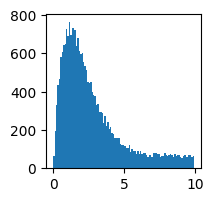

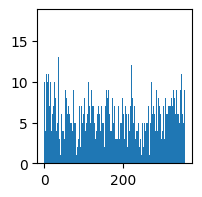

In [44]:
fig,ax=plt.subplots(figsize=(2,2))
ax.hist(disps, bins=np.arange(0,10,.1))
plt.show()
plt.close()

fig,ax=plt.subplots(figsize=(2,2))
ax.hist(angles, bins=(np.arange(0,360,0.1)))
plt.show()
plt.close()

In [40]:
def circular_hist(ax, x, bins=16, density=True, offset=0, gaps=True):
    """
    Produce a circular histogram of angles on ax.

    Parameters
    ----------
    ax : matplotlib.axes._subplots.PolarAxesSubplot
        axis instance created with subplot_kw=dict(projection='polar').

    x : array
        Angles to plot, expected in units of radians.

    bins : int, optional
        Defines the number of equal-width bins in the range. The default is 16.

    density : bool, optional
        If True plot frequency proportional to area. If False plot frequency
        proportional to radius. The default is True.

    offset : float, optional
        Sets the offset for the location of the 0 direction in units of
        radians. The default is 0.

    gaps : bool, optional
        Whether to allow gaps between bins. When gaps = False the bins are
        forced to partition the entire [-pi, pi] range. The default is True.

    Returns
    -------
    n : array or list of arrays
        The number of values in each bin.

    bins : array
        The edges of the bins.

    patches : `.BarContainer` or list of a single `.Polygon`
        Container of individual artists used to create the histogram
        or list of such containers if there are multiple input datasets.
    """
    # Wrap angles to [-pi, pi)
    x = (x+np.pi) % (2*np.pi) - np.pi
    # Force bins to partition entire circle
    if not gaps:
        bins = np.linspace(-np.pi, np.pi, num=bins+1)
    # Bin data and record counts
    n, bins = np.histogram(x, bins=bins)
    # Compute width of each bin
    widths = np.diff(bins)
    # By default plot frequency proportional to area
    if density:
        # Area to assign each bin
        area = n / x.size
        # Calculate corresponding bin radius
        radius = (area/np.pi) ** .5
    # Otherwise plot frequency proportional to radius
    else:
        radius = n
    # Plot data on ax
    patches = ax.bar(bins[:-1], radius, zorder=1, align='edge', width=widths,
                     edgecolor='k', fill=True, linewidth=1)
    # Set the direction of the zero angle
    ax.set_theta_offset(offset)
    # Remove ylabels for area plots (they are mostly obstructive)
    if density:
        ax.set_yticks([])
    ax.set_theta_offset(0)
    ax.set_yticklabels([])
    return n, bins, patches

(array([613, 584, 640, 597, 604, 576, 588, 593, 607, 590, 648, 646, 701,
        754, 812, 900, 884, 858, 755, 709, 633, 629, 609, 593, 601, 599,
        622, 612, 625, 652, 611, 586]),
 array([-3.14157848e+00, -2.94523222e+00, -2.74888595e+00, -2.55253969e+00,
        -2.35619343e+00, -2.15984716e+00, -1.96350090e+00, -1.76715464e+00,
        -1.57080837e+00, -1.37446211e+00, -1.17811585e+00, -9.81769583e-01,
        -7.85423320e-01, -5.89077056e-01, -3.92730793e-01, -1.96384529e-01,
        -3.82660075e-05,  1.96307997e-01,  3.92654261e-01,  5.89000524e-01,
         7.85346788e-01,  9.81693051e-01,  1.17803931e+00,  1.37438558e+00,
         1.57073184e+00,  1.76707811e+00,  1.96342437e+00,  2.15977063e+00,
         2.35611690e+00,  2.55246316e+00,  2.74880942e+00,  2.94515569e+00,
         3.14150195e+00]),
 <BarContainer object of 32 artists>)

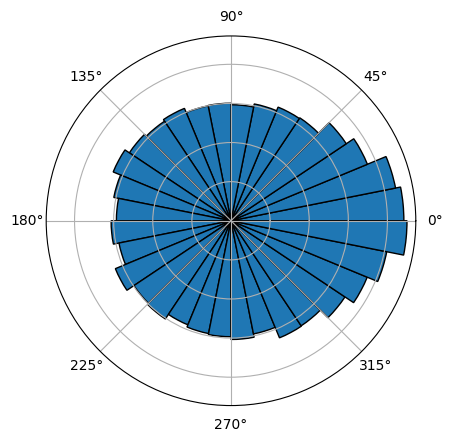

In [41]:
angles_rad = np.array([math.radians(f) for f in angles])
# Construct figure and axis to plot on
fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection='polar'))
circular_hist(ax, angles_rad, offset=np.pi/2, density=False, bins=32)

In [3]:
tracks['rel_x'] = tracks['x'] - grouped['x'].transform('first')
tracks['rel_y'] = tracks['y'] - grouped['y'].transform('first')
tracks['single_frame_disp'] =((grouped['rel_x'].diff(periods=1)**2) + (grouped['rel_y'].diff(periods=1)**2))**.5
tracks['r'] = ((tracks['rel_x'])**2 + (tracks['rel_y'])**2)**.5
tracks.fillna(0, inplace=True)

NameError: name 'tracks' is not defined